## 組合せ最適化問題
量子コンピュータで最適化問題を解くには、イジングモデルといわれる物理モデルを利用する。

## QUBO定式化
QUBOは問題の答えが小さいほうが正解になるように設定された式です。式の形は、

$$
QUBO = -\sum_i h_i q_i -\sum_{i,j}J_{ij}q_iq_j
$$

となっている。iとjは点を表し、hはバイアス（局所磁場）、Jは相互作用と呼ばれます。この式ではqは量子ビットを表し0か1を取ります（イジングの場合は+1か-1）。
私たちはhとJを問題として設定し、qの値を求めます。

## 問題設定の仕方
問題の設定の仕方は、グラフ問題というものに問題を落とすことで計算できますが、いくつか問題を解くことでコツをつかめます。

主に問題のコスト関数は二種類の式を考える必要があります。

１．小さくしたいコスト関数  
２．満たすべき条件（制約条件）

この二つを別々に設計し、つなげることで実装できます。片方しかない式もあります。

## 使うツール

networkx（ネットワークグラフを書く）  
matplotlib（各種のグラフを書く）  
numpy（数値ライブラリ）  

In [1]:
!pip install --quiet networkx matplotlib

## 3-1.グラフ分割問題
頂点と辺からなるグラフを二つのグループの頂点の数がなるべく同じになるように分け、異なるグループ同士の頂点を結ぶ辺の数を最小にする。

### イジング式
今回は便宜的に-1と+1からなるイジング式を使います。この問題は二つの式から成り立ちます。異なるグループに分けるコスト$H_A$と異なるグループの頂点を結ぶコスト$H_B$です。

$$
H_A = (\sum^N_{i=1} z_i)^2
$$

$$
H_B = \sum_{i,j \in E} \frac{1 - z_i z_j}{2}
$$

つないだ式。つなぐときには調整パラメーターが必要になりますので、$\lambda$を付けました。
$$
H = H_A + \lambda*H_B = (\sum^N_{i=1} z_i)^2 + \lambda\sum_{i,j \in E} \frac{1 - z_i z_j}{2}
$$

### 問題設定

下記のようなグラフを二つのグループに分割し、グループ間の辺の数を最小にします。

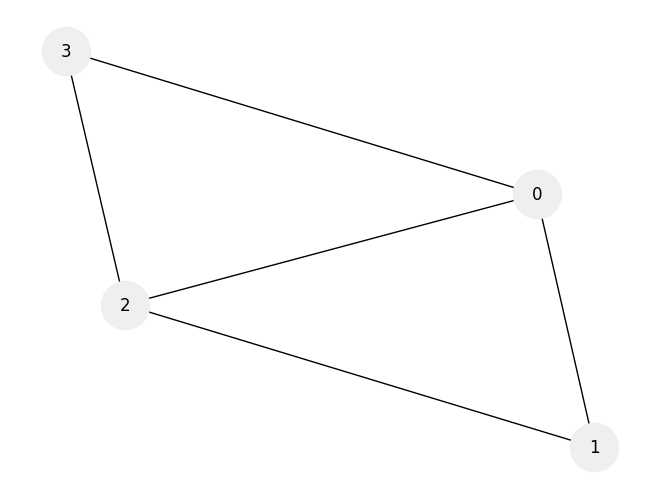

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

N = 4

G = nx.Graph()
G.add_nodes_from(nx.path_graph(N))
G.add_edges_from([(0,1), (0,2), (0,3),(1,2),(2,3)])
nx.draw(G, **options)

In [4]:
import numpy as np

#いじんぐスピンではなくQUBOで


#隣接行列
A = np.triu(nx.to_numpy_matrix(G))
print(A)

[[0. 1. 1. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]


In [54]:
#式A
HA = sum([q[i] for i in range(N)])

#式B
HB = 0.0
for i in range(n):
    for j in range(i+1,n):
        if(A[i,j] == 1):
            HB += (1-q[i]*q[j])/2

#式をつなげます。調整変数を100にしています。
M = 100
H = M*HA**2 + HB

  q[0] q[1] q[2] q[3] energy num_oc.
0    1    1    0    0    3.0       1
4    0    0    1    1    3.0       1
5    1    1    0    0    3.0       1
6    0    1    1    0    3.0       1
7    1    0    0    1    3.0       1
8    1    0    0    1    3.0       1
1    0    1    0    1    4.0       1
2    0    1    0    1    4.0       1
3    0    1    0    1    4.0       1
9    1    0    1    0    4.0       1
['BINARY', 10 rows, 10 samples, 4 variables]


4つの頂点が2つのグループに分かれました。異なるグループの間を結ぶ辺の数は最小で3となっています。答えが1010の場合にはコストが上がっており、辺の数は4となるので、最適ではなくなることから確認できます。以上です。

## 3-2. グラフカラーリング
n頂点と辺からなるグラフにおいて、隣接する頂点と異なるm種類の色で塗り分ける問題。

### QUBO
一つの頂点につきm色を割り当てる制約条件と、隣接する色同士が選ばれないようにペナルティを課す条件を結合します。必要な量子ビット数はm色*n頂点でm*nとなる。

$$
H_A = \sum_{v} (1 - \sum_{i=1}^{m}q_{v,i})^2
$$

$$
H_B = \sum_{(uv) \in E}^{n} \sum_{i=1}^{m} q_{u,i}*q_{v,i}
$$

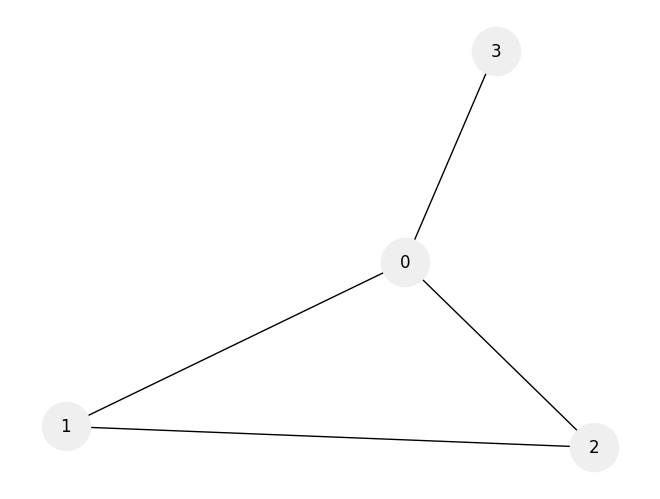

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

n = 4 #頂点数
m = 3 #塗分ける色の数

G = nx.Graph()
G.add_nodes_from(nx.path_graph(n))
G.add_edges_from([(0,1), (0,2), (0,3),(1,2)])
nx.draw(G, **options)

In [29]:
from tytan import *
import sympy as sym

#今回は12量子ビット
N = n*m
q = sym.symbols("q_{0:12}")

#隣接行列
A = np.triu(nx.to_numpy_matrix(G))

#色の通し番号を格納
b = np.zeros((n,m))

#後で利用するノードの色を表示するための辞書
my_dict = {}

#色を格納
num = 0
for v in range(n):
    for i in range(m):
        b[v][i] = num
        my_dict[num] = [str(v),i]
        num += 1

#色を選択するQUBO
h_1= 0.0
const_h = 0.0
for v in range (n):
    for i in range(m):
        const_h += q[int(b[v,i])]
        
    h_1 += (1 - const_h)**2
    const_h = 0.0

#隣接するノードで同じ色が選択されないQUBO
h_2 = 0.0    
for u in range(n):
    for v in range(n):
        for i in range(m):
            if(A[u,v]==1):
                h_2 += q[int(b[u,i])]*q[int(b[v,i])]

#QUBOを統合
H = h_1 + h_2

In [33]:
# Compileクラスを使用して、QUBOを取得
Q, offset = qubo.Compile(H).get_qubo()

# サンプラーを選択
solver = sampler.SASampler()

#クラウドサンプラーの場合
#API_KEY = "API key"
#solver = sampler.NQSSampler()
#result = solver.run(Q, api_key=API_KEY)

# 計算
result = solver.run(Q, shots=100)
#print(result)

print("Sample =", result[0][0])
print("Cost =", result[0][1] + offset)

Sample = {'q_{0}': 0.0, 'q_{10}': 0.0, 'q_{11}': 0.0, 'q_{1}': 0.0, 'q_{2}': 1.0, 'q_{3}': 0.0, 'q_{4}': 1.0, 'q_{5}': 0.0, 'q_{6}': 1.0, 'q_{7}': 0.0, 'q_{8}': 0.0, 'q_{9}': 1.0}
Cost = 0


In [31]:
values_list = [0,0,1,0,1,0,1,0,0,1,0,0]

for i in range(N):
    if(values_list[i]==1):
        print(my_dict[i])

['0', 2]
['1', 1]
['2', 0]
['3', 0]
